**Step 1 – Mount Google Drive & Setup & Libraries**

In [18]:
from google.colab import drive
drive.mount('/content/drive')

!pip install keras-tcn --quiet

import pandas as pd, numpy as np, matplotlib.pyplot as plt, yfinance as yf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tcn import TCN

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [19]:
import os
import numpy as np
import random
import tensorflow as tf

# ============================
# Global Configuration
# ============================

# Define base project folder
BASE = "/content/drive/My Drive/GoldForecasting_Project (ISY5002)"
DATA = os.path.join(BASE, "Data")
MODELS = os.path.join(BASE, "Models", "TCN")
OUT = os.path.join(BASE, "Outputs")

# ----------------------------
# Global Random Seed (for TCN_v2)
# ----------------------------
SEED = 99  # You can change this to any integer for your version control (e.g., 99 for TCN_v2)
os.environ['PYTHONHASHSEED'] = str(SEED)
np.random.seed(SEED)
random.seed(SEED)
tf.random.set_seed(SEED)

print(f"✅ Global SEED fixed at {SEED} for TCN_v2 reproducibility.\n")

# ----------------------------
# Print path summary
# ----------------------------
print("Paths set:")
print("DATA:", DATA)
print("MODELS:", MODELS)
print("OUTPUTS:", OUT)


✅ Global SEED fixed at 99 for TCN_v2 reproducibility.

Paths set:
DATA: /content/drive/My Drive/GoldForecasting_Project (ISY5002)/Data
MODELS: /content/drive/My Drive/GoldForecasting_Project (ISY5002)/Models/TCN
OUTPUTS: /content/drive/My Drive/GoldForecasting_Project (ISY5002)/Outputs


**Step 2 – Load & Prepare Gold Dataset**

In [20]:
# Download COMEX gold futures (GC=F)
df = yf.download("GC=F", start="2021-01-01", end="2025-12-31", interval="1d")
df.reset_index(inplace=True)
df.rename(columns={'Adj Close': 'Adj_Close', 'Volume': 'Vol'}, inplace=True)

# Add daily change %
df['Change'] = df['Close'].pct_change() * 100
df.dropna(inplace=True)

print("Rows:", len(df), "Date range:", df['Date'].min(), "→", df['Date'].max())
df.head()


/tmp/ipython-input-2989582751.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download("GC=F", start="2021-01-01", end="2025-12-31", interval="1d")
[*********************100%***********************]  1 of 1 completed

Rows: 1210 Date range: 2021-01-05 00:00:00 → 2025-10-24 00:00:00


Price,Date,Close,High,Low,Open,Vol,Change
Ticker,,GC=F,GC=F,GC=F,GC=F,GC=F,
1,2021-01-05,1952.699951,1952.699951,1941.300049,1941.699951,113,0.411375
2,2021-01-06,1906.900024,1959.900024,1901.500000,1952.000000,331,-2.345467
3,2021-01-07,1912.300049,1926.699951,1912.000000,1922.599976,122,0.283183
4,2021-01-08,1834.099976,1908.000000,1834.099976,1908.000000,60,-4.089320
5,2021-01-11,1849.599976,1849.599976,1826.500000,1826.500000,20,0.845101


**Step 3 – Feature Selection & Scaling**

In [21]:
features = ['Open','High','Low','Close','Change']
target = 'Close'

scaler = MinMaxScaler()
scaled = scaler.fit_transform(df[features])

print("Scaled shape:", scaled.shape)


Scaled shape: (1210, 5)


**Step 4 – Create Sequences**

In [22]:
X, y = [], []
seq_len = 20  # 20-day lookback

for i in range(seq_len, len(scaled)):
    X.append(scaled[i-seq_len:i])
    y.append(scaled[i][features.index(target)])

X, y = np.array(X), np.array(y)
print("X:", X.shape, "| y:", y.shape)


X: (1190, 20, 5) | y: (1190,)


**Step 5 – Train / Validation / Test Split**

In [23]:
# STEP 5 – Train / Validation / Test Split (70/15/15) with SEED Reference

# Ensure reproducibility (use same SEED defined earlier, e.g. SEED = 42)
print(f"Using SEED = {SEED} for dataset split consistency")

# Define split ratios
train_ratio = 0.70
val_ratio   = 0.15
test_ratio  = 0.15  # implicitly 1 - train_ratio - val_ratio

# Compute sizes
total_samples = len(X)
train_size = int(total_samples * train_ratio)
val_size   = int(total_samples * val_ratio)
test_size  = total_samples - train_size - val_size

# Sequential split (no shuffle, important for time series forecasting)
X_train, y_train = X[:train_size], y[:train_size]
X_val,   y_val   = X[train_size:train_size + val_size], y[train_size:train_size + val_size]
X_test,  y_test  = X[train_size + val_size:], y[train_size + val_size:]

# Display shapes
print("Train:", X_train.shape, "| Val:", X_val.shape, "| Test:", X_test.shape)


Using SEED = 99 for dataset split consistency
Train: (833, 20, 5) | Val: (178, 20, 5) | Test: (179, 20, 5)


**Step 6 – Build Simplified TCN**

In [24]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input
from tcn import TCN

model = Sequential([
    Input(shape=(X_train.shape[1], X_train.shape[2])),
    TCN(nb_filters=64, kernel_size=3, dilations=(1, 2, 4, 8), dropout_rate=0.1),
    Dense(32, activation='relu'),
    Dropout(0.1),
    Dense(1, activation='linear')  # <--- use linear for regression (no cutoff)
])

model.compile(optimizer='adam', loss='mse')
model.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ tcn_1 (TCN)                     │ (None, 64)             │        87,872 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 89,985 (351.50 KB)

 Trainable params: 89,985 (351.50 KB)

 Non-trainable params: 0 (0.00 B)

**Step 7 – Train Model**

In [25]:
callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)
]

history = model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=32,
    validation_data=(X_val, y_val),
    callbacks=callbacks,
    verbose=1,
    shuffle=False
)


Epoch 1/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 6s 40ms/step - loss: 0.4421 - val_loss: 0.0031 - learning_rate: 0.0010
Epoch 2/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0281 - val_loss: 0.0197 - learning_rate: 0.0010
Epoch 3/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0190 - val_loss: 0.0280 - learning_rate: 0.0010
Epoch 4/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0093 - val_loss: 0.0013 - learning_rate: 0.0010
Epoch 5/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0069 - val_loss: 0.0017 - learning_rate: 0.0010
Epoch 6/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0045 - val_loss: 0.0053 - learning_rate: 0.0010
Epoch 7/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0055 - val_loss: 0.0023 - learning_rate: 0.0010
Epoch 8/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0034 - val_loss: 0.0090 - learning_rate: 5.0000e-04
Epoch 9/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0028 - val_loss: 0.0041 - learning_rate: 5.0000e-04


**Step 8 – Predict & Evaluate**

In [26]:
# ============================================================
# Step 8 – Predict & Evaluate (on scaled data)
# ============================================================

y_pred = model.predict(X_test)

from sklearn.metrics import mean_squared_error, mean_absolute_error
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae  = mean_absolute_error(y_test, y_pred)
mape = np.mean(np.abs((y_test - y_pred) / (np.abs(y_test) + 1e-8))) * 100

print(f"RMSE (scaled): {rmse:.4f} | MAE: {mae:.4f} | MAPE: {mape:.2f}%")


6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 252ms/step
RMSE (scaled): 0.0735 | MAE: 0.0558 | MAPE: 18.62%


**Step 9 – Inverse Transform (Back to USD)**

In [27]:
# ============================================================
# Step 9 – Inverse Transform (Back to USD)
# ============================================================

def inverse_transform(values):
    dummy = np.zeros((len(values), len(features)))
    dummy[:, features.index(target)] = values.reshape(-1)
    return scaler.inverse_transform(dummy)[:, features.index(target)]

actual_usd = inverse_transform(y_test)
pred_usd   = inverse_transform(y_pred)

# Optional: light smoothing
pred_usd = pd.Series(pred_usd).rolling(window=3, center=True).mean().bfill().ffill()


**Step 10 – Plot Actual vs Predicted with Red Dotted Line**

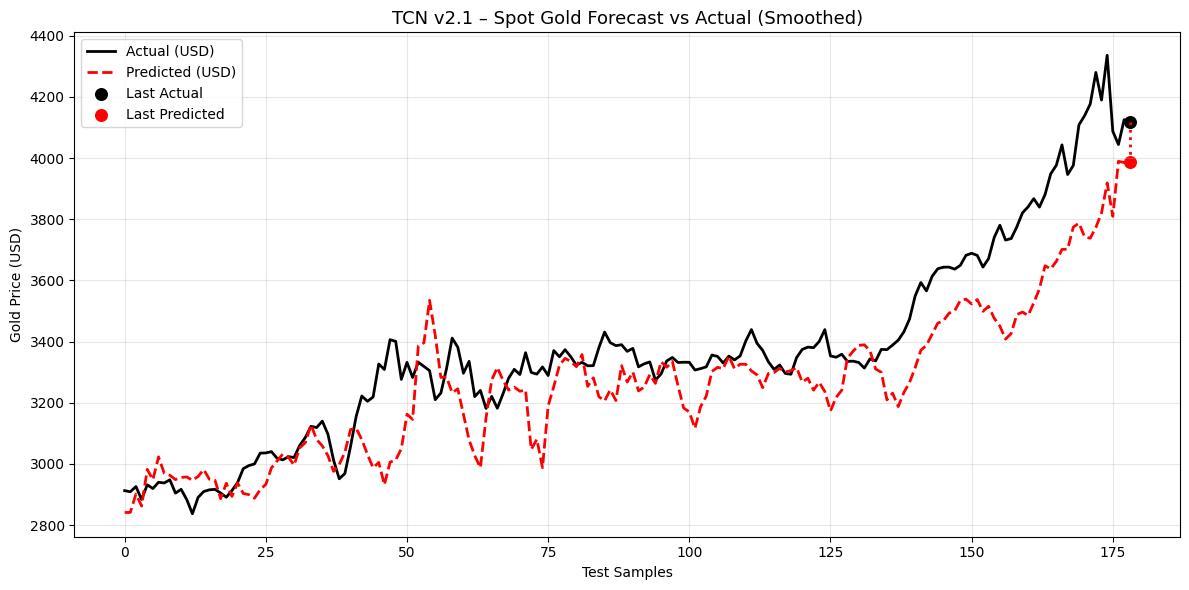

In [28]:
# ============================================================
# Step 10 – Plot Actual vs Predicted (Red Dotted)
# ============================================================

plt.figure(figsize=(12,6))
plt.plot(actual_usd, color='black', label='Actual (USD)', linewidth=2)
plt.plot(pred_usd, color='red', linestyle='--', label='Predicted (USD)', linewidth=2)

# Add last point connector
plt.scatter(len(actual_usd)-1, actual_usd[-1], color='black', s=70, label="Last Actual")
plt.scatter(len(actual_usd)-1, pred_usd.iloc[-1], color='red', s=70, label="Last Predicted")
plt.plot([len(actual_usd)-1, len(actual_usd)-1],
         [actual_usd[-1], pred_usd.iloc[-1]], color='red', linestyle='dotted', linewidth=2)

plt.title("TCN v2.1 – Spot Gold Forecast vs Actual (Smoothed)", fontsize=13)
plt.xlabel("Test Samples"); plt.ylabel("Gold Price (USD)")
plt.legend(); plt.grid(alpha=0.3); plt.tight_layout()
plt.show()


**Step 11 – Directional Accuracy & Confusion Matrix**

Directional Accuracy: 61.80%


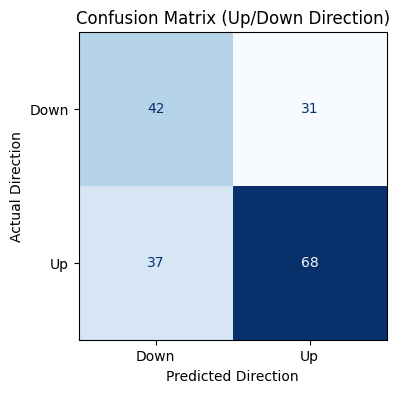

In [29]:
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

# --- Ensure both arrays are NumPy arrays (not pandas Series) ---
actual_arr = np.array(actual_usd).flatten()
pred_arr   = np.array(pred_usd).flatten()

# --- Convert to binary direction (Up=1, Down=0) ---
actual_direction = (actual_arr[1:] > actual_arr[:-1]).astype(int)
predicted_direction = (pred_arr[1:] > pred_arr[:-1]).astype(int)

# --- Directional Accuracy ---
directional_acc = accuracy_score(actual_direction, predicted_direction) * 100
print(f"Directional Accuracy: {directional_acc:.2f}%")

# --- Confusion Matrix ---
cm = confusion_matrix(actual_direction, predicted_direction)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Down", "Up"])

# --- Plot ---
fig, ax = plt.subplots(figsize=(5, 4))
disp.plot(ax=ax, cmap=plt.cm.Blues, colorbar=False)
plt.title("Confusion Matrix (Up/Down Direction)")
plt.xlabel("Predicted Direction")
plt.ylabel("Actual Direction")
plt.grid(False)
plt.show()


**Step 12 – Export Results + Save TCN_v2 Model (.keras + .joblib+.csv+requirements)**

In [30]:
# STEP 12 – Export Results + Save + Download TCN_v2 Model (.keras + .joblib + .csv + requirements)
from google.colab import files
from joblib import dump
import pandas as pd
import os

# ====================================
# 1️⃣ Prepare results DataFrame
# ====================================
test_start_idx = seq_len + len(X_train) + len(X_val)
test_dates = df['Date'].iloc[test_start_idx:].reset_index(drop=True)

output_df = pd.DataFrame({
    'Date': test_dates,
    'Actual_Close_USD': actual_usd.ravel(),
    'Predicted_Close_USD': pred_usd.ravel()
})

# Save predictions CSV
csv_name = "tcn_v2_improved_output.csv"
csv_path = os.path.join(MODELS, csv_name)
output_df.to_csv(csv_path, index=False)
print(f"✅ Results saved to {csv_path}")

# ====================================
# 2️⃣ Save model in both formats (.keras & .joblib)
# ====================================
keras_name = "tcn_v2_improved.keras"
keras_path = os.path.join(MODELS, keras_name)
model.save(keras_path)
print(f"✅ Model saved as {keras_path}")

joblib_name = "tcn_v2_improved.joblib"
joblib_path = os.path.join(MODELS, joblib_name)
dump(model, joblib_path)
print(f"✅ Model also saved as {joblib_path}")

# ====================================
# 3️⃣ Generate & Save requirements file
# ====================================
req_name = "requirements_tcn_v2.txt"
req_path = os.path.join(MODELS, req_name)
!pip freeze > "{req_path}"
print(f"✅ Requirements saved as {req_path}")

# ====================================
# 4️⃣ Download all files to local system (optional)
# ====================================
files.download(csv_path)
files.download(keras_path)
files.download(joblib_path)
files.download(req_path)
print("📥 All files downloaded successfully to your local machine.")


/tmp/ipython-input-1747813549.py:16: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  'Predicted_Close_USD': pred_usd.ravel()


✅ Results saved to /content/drive/My Drive/GoldForecasting_Project (ISY5002)/Models/TCN/tcn_v2_improved_output.csv
✅ Model saved as /content/drive/My Drive/GoldForecasting_Project (ISY5002)/Models/TCN/tcn_v2_improved.keras
✅ Model also saved as /content/drive/My Drive/GoldForecasting_Project (ISY5002)/Models/TCN/tcn_v2_improved.joblib
✅ Requirements saved as /content/drive/My Drive/GoldForecasting_Project (ISY5002)/Models/TCN/requirements_tcn_v2.txt


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

📥 All files downloaded successfully to your local machine.
